<a href="https://colab.research.google.com/github/skanderzoghlami/NLP-Sentiment-Analysis-on-tunisian-words-/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
from google.colab import files
uploader = files.upload()
df = pd.read_csv("Train.csv")
df.head()

Saving Train.csv to Train.csv


,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade

     |████████████████████████████████| 24.2MB 167kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


In [ ]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# Stop words delimit the ending of a phrase
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = [ "ID","text","label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "1"
NEGATIVE = "-1"
NEUTRAL = "0"

SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
print("Dataset size:", len(df))
df.head(5)

Dataset size: 70000


,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [ ]:
target_cnt = Counter(df.label)

Text(0.5, 1.0, 'Dataset labels distribuition')

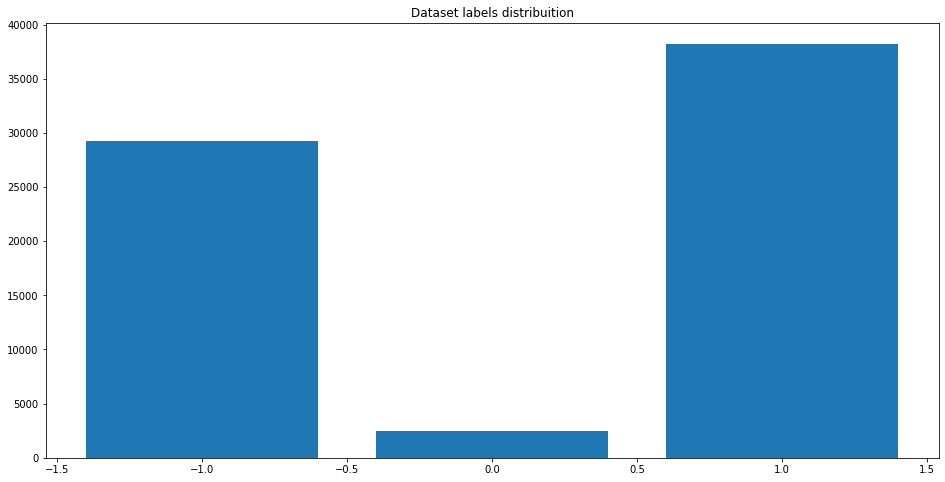

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70000 non-null  object
 1   text    70000 non-null  object
 2   label   70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
df.label.value_counts()

1     38239
-1    29295
0      2466
Name: label, dtype: int64

In [ ]:
decode_map = {-1: "-1", 0: "1", 1: "1"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.label = df.label.apply(lambda x: decode_sentiment(x))

In [ ]:
df.label.value_counts()

1     40705
-1    29295
Name: label, dtype: int64

2021-03-03 13:31:05,295 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-03 13:31:05,299 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Dataset labels distribuition')

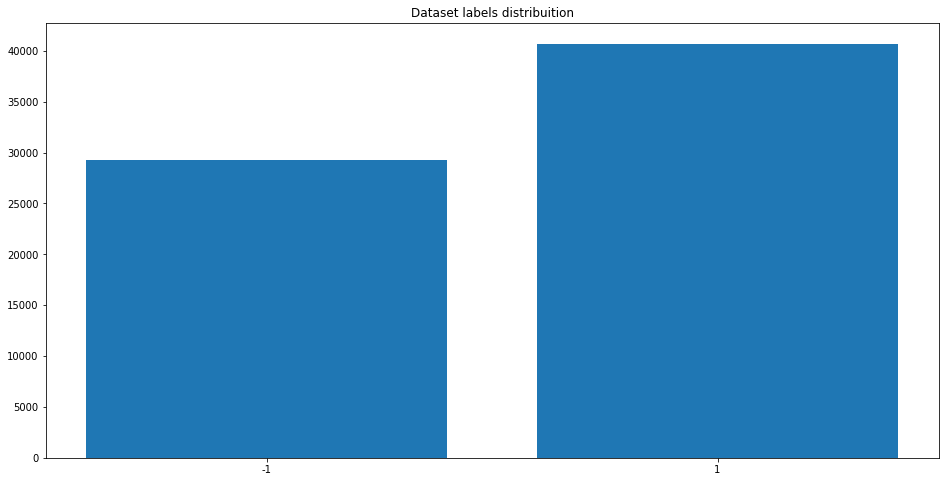

In [ ]:


target_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")



In [ ]:
#stop_words = stopwords.words("french")
stemmer = SnowballStemmer("french")
stop_words= ['kol','ou','w','wa','mela','kima','ana','eni','ena','enti','enta','entouma','el','kont','bech','entom','ezouz','lkol','3lech','3leh','lweh','lwech','barcha','taw','men','mara','eli','m3a','5ater','howa','heya','houma','a7na','ahna','na7na','fi','e5er','o5ra','o5rin','7ata','hata','m3a','fi','ye5i','kol','win']
sw= stopwords.words("french")
sw2 = stopwords.words("english")
stop_words = stop_words + sw + sw2


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 7.3 s, sys: 47.5 ms, total: 7.35 s
Wall time: 8.09 s


In [ ]:
df.text

0        3sbaaaaaaaaaaaaaaaaaaaa lek seim riahi 3sbaaaa...
1                cha3eb fey9elkoum menghir ta7ayoul kressi
2        bereau degage nathef ya slim walahi ya7chiw fi...
3                                                ak slouma
4        titmanou lina 3iid moubarik cha3b lmanyik lf9i...
                               ...                        
69995    pff bayna beli kbira f wejhakk yakhiii rouhi r...
69996    aman lmara jeya zidou t3am9ou fel a7deeth akth...
69997                                winha nakhtabha hhhhh
69998                                         fachel houwa
69999       nchla lyouma nesm3ou a5beer bahiya 3la jem3iya
Name: text, Length: 70000, dtype: object

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 56000
TEST size: 14000


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 368 ms, sys: 53 ms, total: 421 ms
Wall time: 419 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2021-03-03 13:33:37,846 : INFO : collecting all words and their counts
2021-03-03 13:33:37,848 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-03 13:33:37,890 : INFO : PROGRESS: at sentence #10000, processed 83494 words, keeping 32623 word types
2021-03-03 13:33:37,934 : INFO : PROGRESS: at sentence #20000, processed 166432 words, keeping 55214 word types
2021-03-03 13:33:37,973 : INFO : PROGRESS: at sentence #30000, processed 250859 words, keeping 75529 word types
2021-03-03 13:33:38,016 : INFO : PROGRESS: at sentence #40000, processed 334187 words, keeping 93339 word types
2021-03-03 13:33:38,054 : INFO : PROGRESS: at sentence #50000, processed 417580 words, keeping 109965 word types
2021-03-03 13:33:38,077 : INFO : collected 119249 word types from a corpus of 466733 raw words and 56000 sentences
2021-03-03 13:33:38,079 : INFO : Loading a fresh vocabulary
2021-03-03 13:33:38,135 : INFO : effective_min_count=10 retains 5417 unique words (4% of origin

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5417


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-03-03 13:33:45,562 : INFO : training model with 8 workers on 5417 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-03-03 13:33:46,267 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-03 13:33:46,282 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-03 13:33:46,331 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-03 13:33:46,333 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-03 13:33:46,339 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-03 13:33:46,341 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-03 13:33:46,342 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-03 13:33:46,347 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-03 13:33:46,348 : INFO : EPOCH - 1 : training on 466733 raw words (259879 effective words) took 0.8s, 337836 effect

CPU times: user 45.5 s, sys: 386 ms, total: 45.9 s
Wall time: 25 s


(8317980, 14935456)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-03-03 13:35:04,143 : INFO : precomputing L2-norms of word weight vectors


[('always', 0.8170008659362793),
 ('girl', 0.8154698014259338),
 ('beautiful', 0.8115333318710327),
 ('best', 0.8046836853027344),
 ('amazing', 0.8043886423110962),
 ('tooop', 0.7871783375740051),
 ('great', 0.7861613035202026),
 ('algeria', 0.7854702472686768),
 ('work', 0.7794241309165955),
 ('going', 0.7751379609107971)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 119250
CPU times: user 1.19 s, sys: 27.9 ms, total: 1.22 s
Wall time: 1.22 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.42 s


In [ ]:
labels = df_train.label.unique().tolist()
labels

['1', '-1']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (56000, 1)
y_test (14000, 1)


In [ ]:


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)



x_train (56000, 300)
y_train (56000, 1)

x_test (14000, 300)
y_test (14000, 1)


In [ ]:


y_train[:10]



array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(119250, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          35775000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 35,935,501
Trainable params: 160,501
Non-trainable params: 35,775,000
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
50/50 [==============================] - 644s 13s/step - loss: 0.5665 - accuracy: 0.6994 - val_loss: 0.4588 - val_accuracy: 0.7775


2021-03-03 13:48:15,292 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/8
50/50 [==============================] - 654s 13s/step - loss: 0.4771 - accuracy: 0.7598 - val_loss: 0.4432 - val_accuracy: 0.7834


2021-03-03 13:59:09,765 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 3/8
50/50 [==============================] - 670s 13s/step - loss: 0.4633 - accuracy: 0.7679 - val_loss: 0.4342 - val_accuracy: 0.7877


2021-03-03 14:10:19,291 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 4/8
50/50 [==============================] - 656s 13s/step - loss: 0.4570 - accuracy: 0.7709 - val_loss: 0.4293 - val_accuracy: 0.7923


2021-03-03 14:21:15,270 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 5/8
50/50 [==============================] - 655s 13s/step - loss: 0.4508 - accuracy: 0.7718 - val_loss: 0.4270 - val_accuracy: 0.7916


2021-03-03 14:32:10,460 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 6/8
50/50 [==============================] - 652s 13s/step - loss: 0.4434 - accuracy: 0.7777 - val_loss: 0.4216 - val_accuracy: 0.7930


2021-03-03 14:43:02,778 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 7/8
50/50 [==============================] - 654s 13s/step - loss: 0.4403 - accuracy: 0.7789 - val_loss: 0.4199 - val_accuracy: 0.7934


2021-03-03 14:53:57,117 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 8/8
50/50 [==============================] - 654s 13s/step - loss: 0.4376 - accuracy: 0.7806 - val_loss: 0.4177 - val_accuracy: 0.7957


2021-03-03 15:04:51,166 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


CPU times: user 2h 36min 35s, sys: 9min 47s, total: 2h 46min 22s
Wall time: 1h 27min 20s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

14/14 [==============================] - 36s 3s/step - loss: 0.4361 - accuracy: 0.7847

ACCURACY: 0.7847142815589905
LOSS: 0.4361344873905182
CPU times: user 1min 5s, sys: 3.79 s, total: 1min 9s
Wall time: 36.2 s


In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("ya chesmek  ",False)

{'elapsed_time': 0.09382295608520508,
 'label': '1',
 'score': 0.6012781262397766}

In [ ]:
x_test = pd.read_csv('Test.csv')

In [ ]:
x_test.head()

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w barra rabbi m3ak 5ouya
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...


In [ ]:
predict(x_test.text[1],False)

{'elapsed_time': 0.0994102954864502,
 'label': '-1',
 'score': 0.035405516624450684}

In [ ]:
predictions = x_test.ID
values = x_test.text


In [ ]:
x=  pad_sequences(tokenizer.texts_to_sequences(x_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
y=model.predict(x)

In [ ]:
y

array([[0.37535396],
       [0.03540552],
       [0.98259854],
       ...,
       [0.8998578 ],
       [0.04730976],
       [0.86598563]], dtype=float32)

In [ ]:
predictions = x_test.ID
i=0
l=[]
for v in y:
  if v<0.5:
    l.append("-1")
  else:
    l.append("1")
  i+=1 ;
predictions = predictions +','+ l

2021-03-03 15:22:38,532 : INFO : NumExpr defaulting to 2 threads.


In [ ]:
predictions

0        2DDHQW9,-1
1        5HY6UEY,-1
2         ATNVUJX,1
3         Q9XYVOQ,1
4         TOAHLRH,1
            ...    
29995    NHXTL3R,-1
29996     U1YWB2O,1
29997     O3KYLM0,1
29998    W4C38TY,-1
29999     4NNX5QE,1
Name: ID, Length: 30000, dtype: object

In [ ]:
predictions.to_csv("subs.csv", index=False)

In [ ]:
x_test['label']=y

In [ ]:
x_test

,ID,text,label
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik,0.375354
1,5HY6UEY,ye gernabou ye 9a7ba,0.035406
2,ATNVUJX,saber w barra rabbi m3ak 5ouya,0.982599
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh,0.545579
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...,0.924532
...,...,...,...
29995,NHXTL3R,me ihebekch raw,0.498555
29996,U1YWB2O,nchallah rabi m3ak w iwaf9ek mais just 7abit n...,0.991667
29997,O3KYLM0,slim rabi m3ak w e5edem w 5alli l7ossed lemnay...,0.899858
29998,W4C38TY,bara 5alis rouhik yizi mitbal3it jam3iya hlaki...,0.047310


In [ ]:
def classy(x):
  if x>= 0.6 :
    return "1"
  else:
    return "-1"


x_test["label"]= x_test["label"].apply(lambda x:  classy(x))

In [ ]:
x_test

,ID,text,label
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik,1
1,5HY6UEY,ye gernabou ye 9a7ba,-1
2,ATNVUJX,saber w barra rabbi m3ak 5ouya,1
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh,1
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...,1
...,...,...,...
29995,NHXTL3R,me ihebekch raw,1
29996,U1YWB2O,nchallah rabi m3ak w iwaf9ek mais just 7abit n...,1
29997,O3KYLM0,slim rabi m3ak w e5edem w 5alli l7ossed lemnay...,1
29998,W4C38TY,bara 5alis rouhik yizi mitbal3it jam3iya hlaki...,-1


In [ ]:
submit = x_test[["ID","label"]]
submit.to_csv("submissionFinal.csv", index=False)

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'